[参考](https://www.kaggle.com/apapiu/regularized-linear-models)。

得分：$0.12086$。


总结和思考：

1、针对非正态分布的数据，做 $log1p$ 处理是一种常见的手段，只要是偏度大于 $0.75$ 的都做 `log1p` 处理（待确认，因为当时记这句话的时候，没有记录出处）。

2、交叉验证选择超参数；

3、线性回归：使用岭回归和 LASSO 回归；

4、线性回归的系数可以表示特征的重要性，分为正线性相关和负线性相关，LASSO 回归有特征选择的功能；

5、比较厉害的还是 XGBoost，深度学习这个工具不一定好用。


欢迎批评和指导，我的联系方式：

1、电话、微信：13671597056；

2、QQ：121088825；

3、邮件地址：liweiwei1419@gmail.com。



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [2]:
# 先合并起来一起处理，然后再分开，基于 Kaggle 问题的特点，测试数据是确定的，可以这么做
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

In [3]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


针对非正态分布的数据，做 $log1p$ 处理是一种常见的手段。

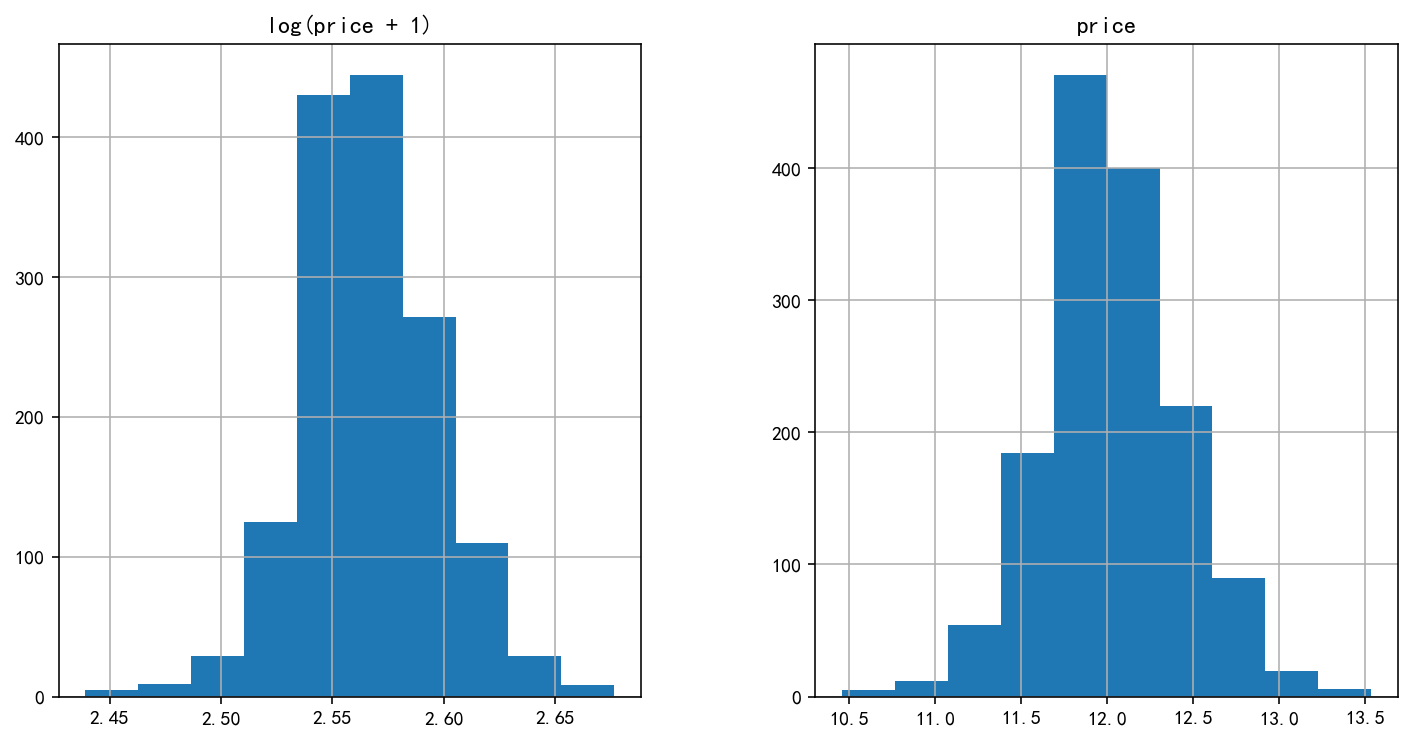

In [45]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

prices = pd.DataFrame()
prices['price'] = train['SalePrice']
prices['log(price + 1)'] = np.log1p(train['SalePrice'])
# prices

prices.hist()
plt.show()

In [5]:
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))  # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

独热编码

In [6]:
all_data = pd.get_dummies(all_data)

In [7]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

分离训练集与测试集。

In [8]:
# creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## 模型训练

因为题目要求用 rmse，所以单独写一个方法。

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [10]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [11]:
cv_ridge

[0.13893637694024322,
 0.13777538277187823,
 0.13501433618086017,
 0.13136184989399582,
 0.1286489244611188,
 0.12782179689257317,
 0.1273373466867077,
 0.127529404397538,
 0.12895888148450071,
 0.1309943785719139,
 0.1331636642337027]

Text(0, 0.5, 'rmse')

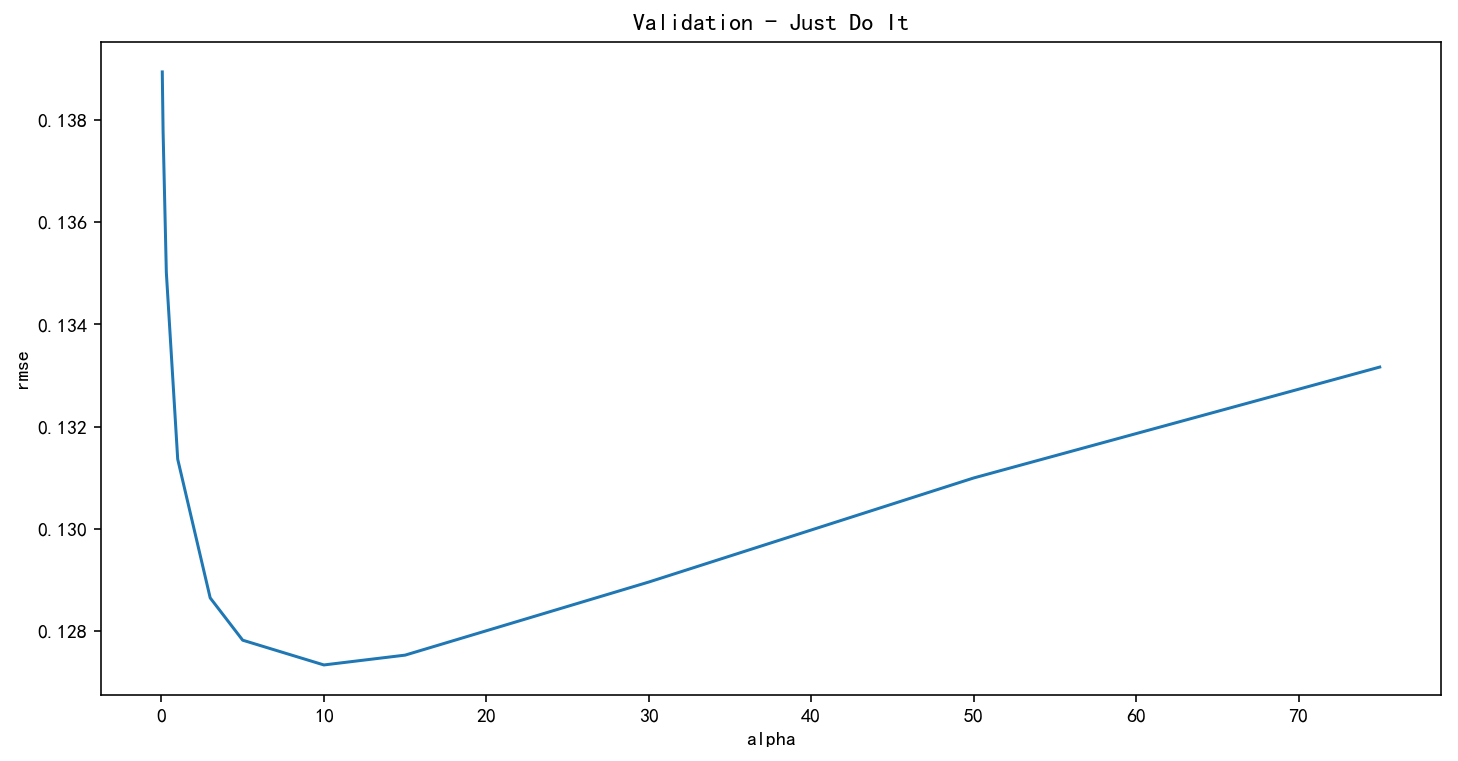

In [12]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
cv_ridge.min()

0.1273373466867077

In [14]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [15]:
rmse_cv(model_lasso).mean()

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of rely

0.12314421090977459

In [16]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
YearBuilt                0.001777
YearRemodAdd             0.000722
MasVnrArea              -0.000194
BsmtFinSF1               0.009292
BsmtFinSF2              -0.001385
BsmtUnfSF               -0.003975
TotalBsmtSF              0.019208
1stFlrSF                 0.030350
2ndFlrSF                -0.003396
LowQualFinSF            -0.003880
GrLivArea                0.400009
BsmtFullBath             0.025674
BsmtHalfBath             0.000000
FullBath                 0.021307
HalfBath                 0.013793
BedroomAbvGr            -0.001004
KitchenAbvGr            -0.009937
TotRmsAbvGrd             0.005079
Fireplaces               0.022117
GarageYrBlt              0.000029
GarageCars               0.038789
GarageArea               0.000051
WoodDeckSF               0.004409
OpenPorchSF              0.001631
EnclosedPorch 

In [17]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


In [18]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

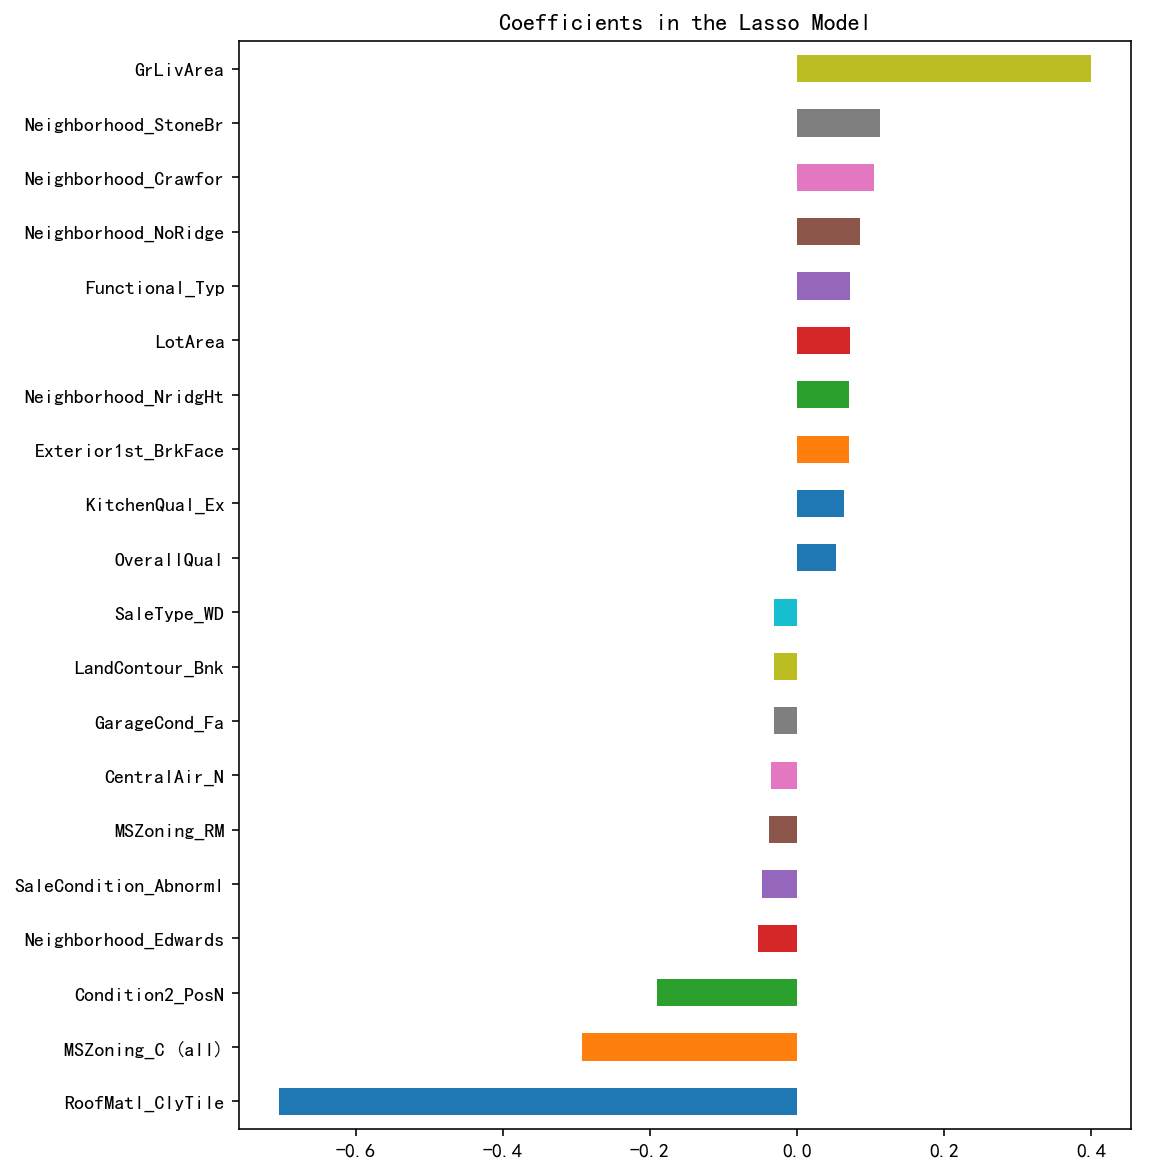

In [19]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

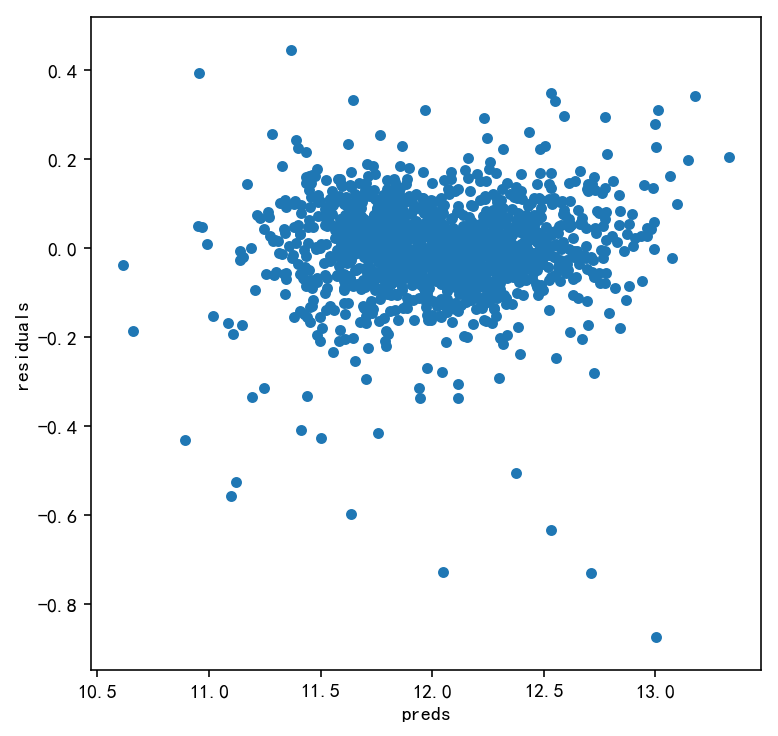

In [20]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## 大杀器来了 xgboost

In [21]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth": 2, "eta": 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

In [22]:
model

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.380516,0.003151,10.380511,0.007226
1,9.345149,0.002914,9.345143,0.007586
2,8.413391,0.002711,8.413386,0.007926
3,7.574888,0.002511,7.575220,0.007951
4,6.820173,0.002320,6.820488,0.007688
5,6.140900,0.002151,6.140680,0.007944
6,5.529502,0.002004,5.530103,0.006854
7,4.979228,0.001866,4.979832,0.006660
8,4.483998,0.001758,4.484702,0.006560
9,4.038296,0.001664,4.038871,0.005896


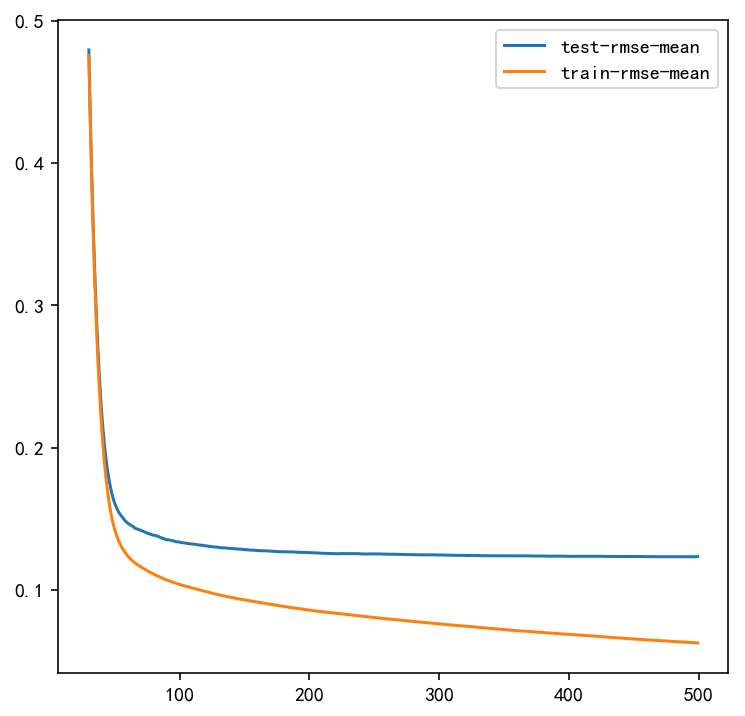

In [23]:
model.loc[30:, ["test-rmse-mean", "train-rmse-mean"]].plot()

In [24]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

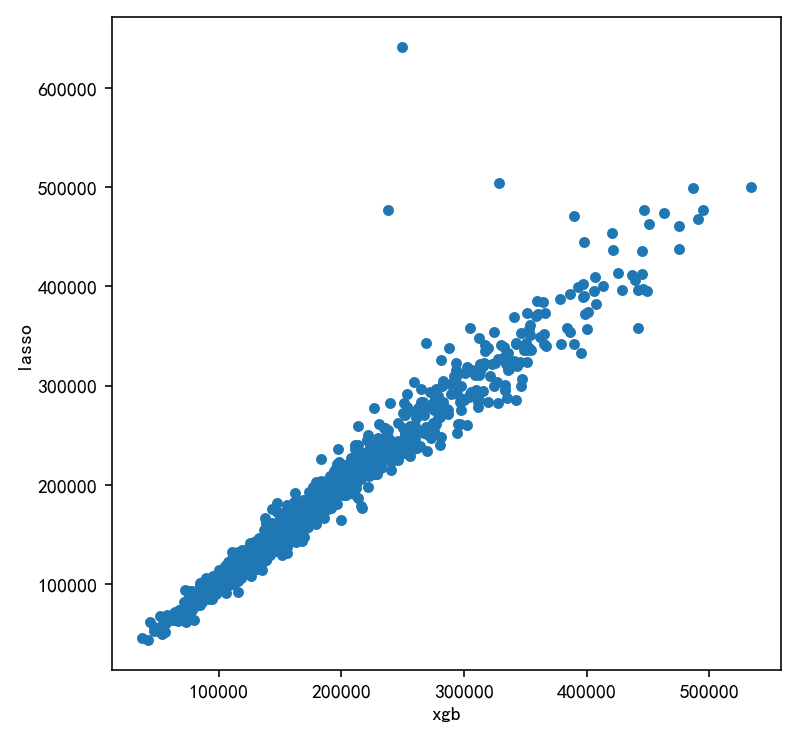

In [26]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [27]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds

In [28]:
solution = pd.DataFrame({"id": test.Id, "SalePrice": preds})
solution.to_csv("ridge_sol.csv", index=False)

## 用深度学习做一下（有问题，暂时不搞了吧，以后再来了解）

In [29]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [30]:
X_train = StandardScaler().fit_transform(X_train)

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [32]:
X_tr.shape

(1095, 288)

In [33]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

Instructions for updating:
Colocations handled automatically by placer.


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [35]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1095 samples, validate on 365 samples
Epoch 1/1
1095/1095 [==============================] - 0s 164us/step - loss: 147.0249 - val_loss: 149.9531


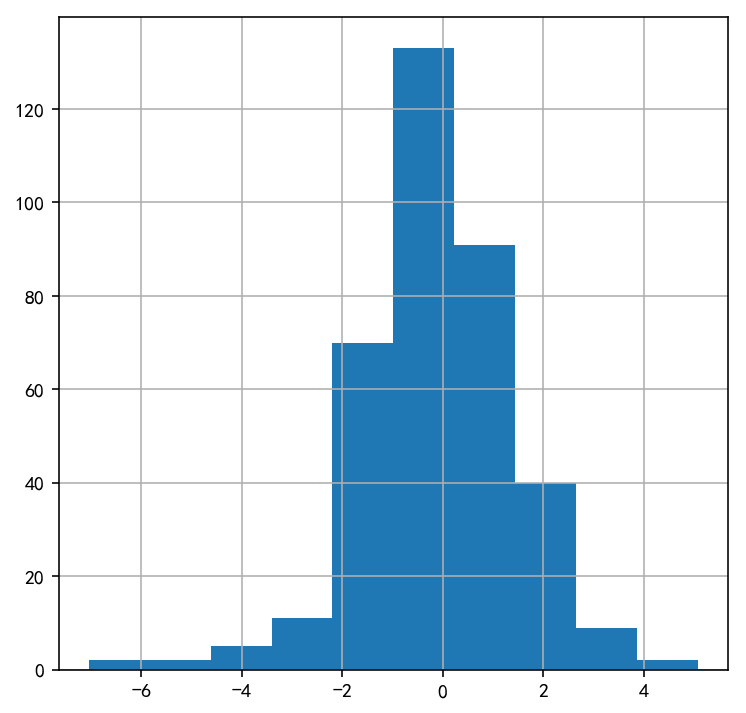

In [36]:
pd.Series(model.predict(X_val)[:,0]).hist()

In [37]:
y_pred = model.predict(X_test)

In [38]:
solution = pd.DataFrame({"id": test.Id, "SalePrice": y_pred.ravel()})
solution.to_csv("../output/keras.csv", index=False)
# 分数 深度学习的分数很差，可能哪里出问题了吧